In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import statsmodels as sm
from statsmodels.imputation import mice
from tqdm import tqdm
import geopandas as gpd


In [25]:
df = pd.DataFrame(np.random.randint(0,1000,size=(100, 52)), columns=list('ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'))
df = df.mask(np.random.random(df.shape) < .2)
df.head()

,A,B,C,D,E,F,G,H,I,J,...,q,r,s,t,u,v,w,x,y,z
0,NaN,289.0,173.0,76.0,632.0,258.0,576.0,NaN,626.0,990.0,...,NaN,NaN,569.0,847.0,193.0,892.0,565.0,45.0,NaN,532.0
1,59.0,715.0,940.0,854.0,NaN,354.0,949.0,519.0,513.0,181.0,...,931.0,NaN,469.0,629.0,469.0,NaN,814.0,NaN,915.0,64.0
2,NaN,212.0,755.0,NaN,819.0,NaN,285.0,906.0,581.0,676.0,...,NaN,NaN,914.0,426.0,221.0,NaN,624.0,588.0,633.0,NaN
3,558.0,NaN,NaN,397.0,170.0,475.0,56.0,494.0,566.0,274.0,...,588.0,63.0,333.0,593.0,536.0,465.0,0.0,399.0,723.0,NaN
4,833.0,NaN,NaN,NaN,930.0,97.0,738.0,73.0,NaN,291.0,...,NaN,589.0,725.0,171.0,635.0,436.0,387.0,522.0,NaN,382.0


In [ ]:
big_time = []
for k in tqdm(range(10,200000,10000)):
    df = pd.DataFrame(np.random.randint(0,k,size=(100, 52)), columns=list('ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'))
    df = df.mask(np.random.random(df.shape) < .4)
    run_time = []
    for i in range(3,df.columns.shape[0],10):
        start = time.time()
        imp=sm.imputation.mice.MICEData(df.iloc[:,:i],perturbation_method='gaussian', k_pmm=2)
        for j in range(10):
            imp.update_all()
        end = time.time()
        run_time.append(end-start)
    big_time.append(run_time)




  0%|                                                                                           | 0/20 [00:00<?, ?it/s]


  5%|████▏                                                                              | 1/20 [01:15<23:56, 75.62s/it]


 10%|████████▎                                                                          | 2/20 [02:25<21:49, 72.75s/it]C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\imputation\mice.py:979: RuntimeWarning: covariance is not positive-semidefinite.
  self.params[vname] = np.random.multivariate_normal(mean=mu, cov=cov)



 15%|████████████▍                                                                      | 3/20 [03:35<20:20, 71.81s/it]


 20%|████████████████▌                                                                  | 4/20 [04:53<19:33, 73.32s/it]


 25%|████████████████████▊                                                              | 5/20 [06:12<18:38, 74.54s/it]


 30%|███████████████████████

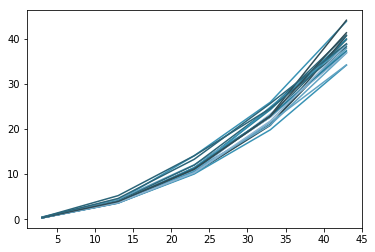

In [67]:
import seaborn as sns
sns.set_palette("PuBuGn_d")

for i in range(20):
    plt.plot(range(3,df.columns.shape[0],10), big_time[i], label=range(10,200000,10000)[i])
    


In [4]:
imputed = gpd.read_file(r'J:\Geology\WSGS\Projects\Critical Minerals\hotspot analysis\max_nure_with_hucs_polygon.shp')
hucs = gpd.read_file(r'J:\Geology\WSGS\GIS\huc_12.shp')
hucs = hucs.to_crs(crs={'init': 'epsg:3732'})
hucs = imputed
hucs['FID'] = hucs.index.values


In [14]:
def GangsterRoll(element):
    Xbar = hucs[element].mean() #calculates the mean value of the element across all HUCS
    S = np.sqrt((((hucs[element])**2).sum()/len(hucs))-(Xbar**2)) #calculates the S value in the denominator
    import scipy.sparse as sp #import bruh
    mat = sp.dok_matrix((len(hucs), len(hucs)), dtype=np.int8) #creates a sparse matrix based on a dictionary of keys from above
    for huc_a, huc_b in neighbors.items(): #this creates a sparse matrix of spatial contiguity weights
        mat[huc_a, huc_b] = 1
        mat = mat.transpose().tocsr()
    z_score = []
    for i in tqdm(range(len(hucs))): #here is the G* function that calculates the z-score
        try:
            row_standardized = mat.toarray()[i]/mat.toarray()[i].sum()
            numerator = ((hucs[element].values*row_standardized).sum())-(row_standardized.sum()*Xbar) #numerator
            denominator = np.sqrt(abs(((row_standardized**2).sum())-(row_standardized.sum())**2)/(len(row_standardized)-1))*S #denominator
            z_score.append(numerator/denominator)
        except:
            z_score.append(np.nan)
    hucs['z_score'] = z_score
    hucs['z_score'].replace([np.inf, -np.inf], np.nan, inplace=True)
    hucs['z_score'].fillna(0, inplace=True)
    

In [17]:
run_time = []

for i in range(1,100):
    start = time.time()
    keys = hucs.loc[0:i].FID #huc basin number
    ds=[]
    for i in range(len(keys)):
        downstream = hucs[hucs['HUC_12'] == hucs.loc[i].HU_12_DS].FID.values
        ds.append(downstream)
    #huc basin downstream of huc basin
    us = []
    for i in range(len(keys)):
        upstream = hucs.loc[hucs['HU_12_DS'] == hucs.loc[i].HUC_12].FID.values
        us.append(upstream)
    lso = []
    for i in range(len(ds)):
        ls = []
        if ds[i].size>0:
            ls.append(ds[i][0])
        else:
            ls.append(-1)
        for j in range(len(us[i])):
            if us[i].size>0:
                ls.append(us[i][j])
            else:
                ls.append(-1)
        lso.append(ls)
    neighbors = dict(zip(keys, lso))
    GangsterRoll('au_ppm')
    end = time.time()
    run_time.append(end-start)


C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\sparse\compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)
  0%|                                                                                         | 0/2382 [00:00<?, ?it/s]C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
100%|████████████████████████████████████████████████████████████████████████████| 2382/2382 [00:02<00:00, 1173.40it/s]


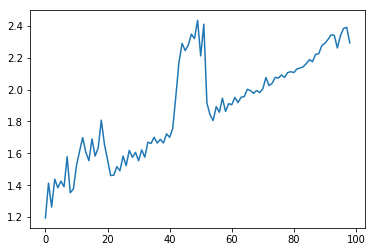

In [18]:
plt.plot(run_time)